In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
from scipy.spatial.distance import mahalanobis,euclidean
from sklearn import metrics

# Load data

In [2]:
batch_num = 1
hidden_num = 15
step_num = 84
elem_num = 1
init_wins = 12

power = pd.read_csv("C:/Users/Bin/Desktop/Thesis/dataset/power.csv",names=["power_demand","label"],skiprows=step_num*init_wins)
test_set = power.power_demand
labels = power.label
wins = power.shape[0]//step_num
test_set_list = [test_set.as_matrix().reshape(wins,batch_num,step_num,elem_num)[a] for a in range(wins)]


In [3]:
# figure out anomaly windows
buffer = [labels[i*step_num:(i+1)*step_num] for i in range(0,labels.size//step_num)]
anomaly_index = []
count = 0
for buf in buffer:
    if "anomaly" in buf.tolist():
        anomaly_index.append(count)
    else:
        pass
    count +=1
print(anomaly_index)

expert = ["normal"]*wins
for x in anomaly_index:
    expert[x] = "anomaly"

[0, 4, 5, 7, 26, 38]


# Load Model

In [4]:
modelpath_root ="C:/Users/Bin/Desktop/Thesis/models/power/"
modelmeta_p = modelpath_root + "_1_15_84_para.ckpt.meta"

sess = tf.Session()
saver = tf.train.import_meta_graph(modelmeta_p) # load trained gragh, but without the trained parameters
saver.restore(sess,tf.train.latest_checkpoint(modelpath_root))
graph = tf.get_default_graph()

p_input = graph.get_tensor_by_name("p_input:0")
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)] 
p_is_training = graph.get_tensor_by_name("is_training_:0")

input_= tf.transpose(tf.stack(p_inputs), [1, 0, 2])    
output_ = graph.get_tensor_by_name("decoder/output_:0")

tensor_mu = graph.get_tensor_by_name("mu:0")
tensor_sigma = graph.get_tensor_by_name("sigma:0")
tensor_threshold = graph.get_tensor_by_name("threshold:0")

loss_ = graph.get_tensor_by_name("decoder/loss:0")
train_ = graph.get_operation_by_name("cond/train_")

mu = sess.run(tensor_mu)
sigma = sess.run(tensor_sigma)
threshold = sess.run(tensor_threshold)

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/models/power/_1_15_84_para.ckpt


In [5]:
print(mu,sigma,threshold)

0.0854842 0.00507233 0.00671047


# Online Phase (With expert)

In [6]:
def scoring(err,mu,sigma):
    
    scores = []
    for e in err:
        scores.append(mahalanobis(e,mu,sigma))

    return scores

In [7]:
def update_parameter(errBuffer,mu,sigma,eta,threshold,score,label):       
        tmp_errBuffer = errBuffer[-3:] if len(errBuffer)>3 else errBuffer
        err_vec_array = np.array(tmp_errBuffer)
        # for univariate  data
        __mu = np.mean(err_vec_array.ravel())
        mu = mu*eta + __mu*(1-eta)

        __sigma =np.var(err_vec_array.ravel())
        sigma = __sigma
        
        __thresold = scores.min()
        f = 0
        for t in range(int(scores.min()*100),int(scores.max()*100),5):
            fbeta,_, _ = evaluate(t/100,score,label)
            __thresold = t/100 if fbeta>f else __thresold
            
        threshold = threshold*eta + __thresold*(1-eta)
        return mu,sigma,threshold

In [8]:
def evaluate(threoshld,scores,label):
    beta = 1
    tn = len(set(scores[ scores > threshold].index) & set( label[label=='anomaly'].index))
    fp = len(set(scores[ scores > threshold].index) & set(label[label=='normal'].index))
    fn = len(set(scores[ scores <= threshold].index) & set( label[label=='anomaly'].index))
    tp = len(set(scores[ scores <= threshold].index) & set(label[label=='normal'].index))
    #tp = abnormal_score[abnormal_score>threshold].size
    #fp = abnormal_score.size-tp
    #fn = normal_score[normal_score>threshold].size
    #tn = normal_score.size- fn

    if tp == 0: 
        print("TP is 0.")
        return 0
    

    P = tp/(tp+fp) # reduce the number of didn't detected anomaly
    R = tp/(tp+fn) # recuce the number of normal points that predicted as abnormal
    fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
    print(tp,fp,fn,tn,fbeta,threshold)
    return fbeta,tp, tn

In [9]:
def plot_roc(fpr,tpr,auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' %auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

TP
FP
FP
FP
TP
TP
FP
TP
FP
retrain...
TN
FP
TN
FP
FP
FP
FP
retrain...
TN
TN
TN
TN
FP
FP
FP
FP
FP
retrain...
TN
TP
TN
TN
FP
TN
TN
TN
FP
FP
TN
FP
FP
retrain...
TP


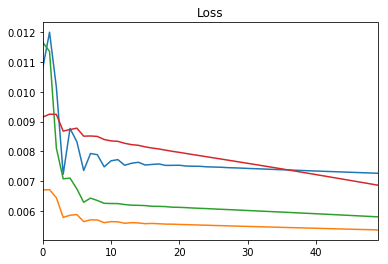

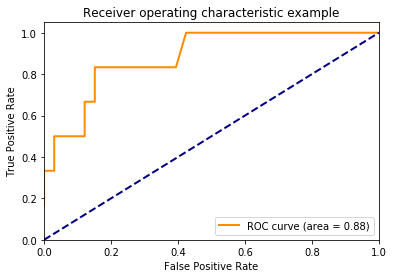

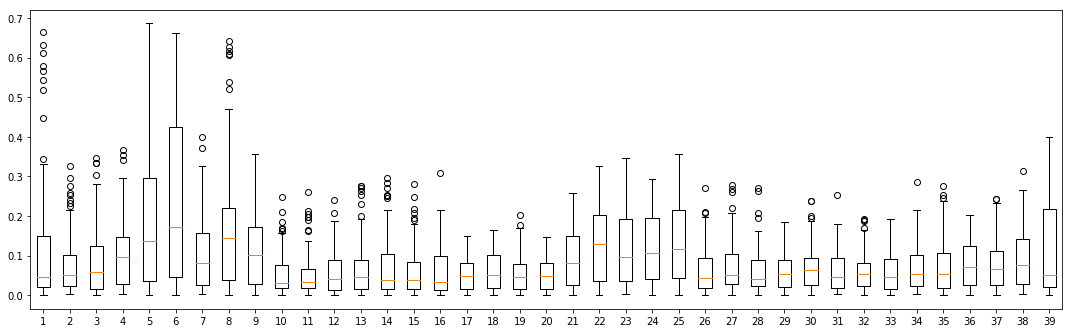

In [10]:
count = 0
n_buf = []
a_buf = []

y = []
output=[]
box = []

all_scores = []

for l in labels:
    if l == "normal":
        y +=[0]
    else: 
        y +=[1]
for data in test_set_list:
    
        prediction = []
        
        (input_n, output_n) = sess.run([input_, output_], {p_input: data, p_is_training: False})

        err = abs(input_n-output_n).reshape(-1,1)
        box.append(err.reshape(-1,))
        
        scores = scoring(err,mu,sigma)
        scores = pd.Series(scores)
        all_scores.append(scores)
        #output += [x for x in scores]
        output +=[scores[scores>threshold].size]
        pred = [scores[b*step_num:(b+1)*step_num] for b in range(batch_num)]
        label = [expert[count*batch_num+b]for b in range(batch_num)]
        
        for index,value in enumerate(pred):
            if value[value>threshold].size>=5: 
                if label[index] == "anomaly":
                    print("TP")                 
                    a_buf.append(data[index])                  
                else:
                    print("FP")                    
                    n_buf.append(data[index])
            else:               
                if label[index] == "anomaly":             
                    print("FN")
                    a_buf.append(data[index])
                else:
                    print("TN")
        count +=1
        

        
        if len(n_buf)>=5:
            print("retrain...")
            loss_list_all=[]

            datalist = np.array(n_buf).reshape(-1,batch_num,step_num,elem_num)
            
            for i in range(50):
                
                loss_list=[]
                for data in datalist:
                    (loss, _) = sess.run([loss_, train_], {p_input: data,p_is_training : True})
                    loss_list.append(loss)
                #print('Retrain-iter %d:' % (i + 1), np.array(loss_list).mean())
                loss_list_all.append( np.array(loss_list).mean())    
            pd.Series(loss_list_all).plot(title="Loss")
            n_buf = []
                
fpr, tpr, thresholds = metrics.roc_curve(expert, output, pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 5.5)
ax.boxplot(box)

plt.show()